In [1]:
import numpy as np
import pandas as pd
import sys
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from numpy.linalg import cholesky, det, lstsq, inv
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from sklearn.model_selection import KFold
import time

sns.set_style('darkgrid')
np.random.seed(42)

In [2]:
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

line_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

In [24]:
def SE(X1, X2, l, amp=1.0):
    '''
    Squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = cdist(X1, X2, 'sqeuclidean')
    val = (amp ** 2) * np.exp(-np.exp(np.log(0.5)- 2 * np.log(abs(l+0.0000001))) * sqdist)
    #val = amp * np.exp(-np.exp(np.log(0.5)- 2 * np.log(abs(l+0.0000000000001))) * sqdist)
    return val

In [22]:
def SE_amp(X1, X2, amp, l=1.0):
    '''
    Squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = cdist(X1, X2, 'sqeuclidean')
    #val = (amp ** 2) * np.exp(-np.exp(np.log(0.5)- 2 * np.log(abs(l+0.0000001))) * sqdist)
    val = val = amp * np.exp(-np.exp(np.log(0.5)- 2 * np.log(abs(l+0.0000000000001))) * sqdist)
    
    return val

In [5]:
def Matern_3(xa, xb, mal):
    """matern 3/2  with l"""
    # distance (Euclidian)
    #ma_dist = (np.sqrt(3)/mal) * cdist(xa, xb, 'euclidean')
    ma_dist = np.exp(0.5 * np.log(3) - np.log(abs(mal+0.0000000000001))) * cdist(xa, xb, 'euclidean')
    val = (1+ma_dist)*np.exp(-ma_dist)
    return val

In [6]:
def Gamma_exp(xa, xb, gaml): # set gamma = 1.5
    """Exponentiated quadratic  with l and gamma"""
    #distance (Euclidian)
    #gammaexp_dist = (1/gaml) * cdist(xa, xb, 'euclidean')
    gammaexp_dist = np.exp(-np.log(abs(gaml+0.000000000001))) * cdist(xa, xb, 'euclidean')
    val = np.exp(-np.power(gammaexp_dist, 1.5))
    return val

In [7]:
# define noise term 
noise = np.sqrt(0.5)
# Define the true function that we want to regress on
f_cos = lambda x: (np.cos(x)+x**2).flatten()

n1 = 60  # Number of training points
domain = (-6, 6) # domain of training points

np.random.seed(42)
X1 = np.linspace(domain[0], domain[1], n1).reshape(-1,1)
X2 = np.linspace(domain[0]-2, domain[1]+2, 90).reshape(-1,1)
yerr = np.random.normal(0,noise**2,n1) # gaussian noise 
ytesterr = np.random.normal(0,noise**2,90)
#Y1 = (f_cos(X1) + yerr).reshape(n1,1)
Y1 = f_cos(X1) + yerr
#Y2 = (f_cos(X2) + ytesterr).reshape(90,1)
Y2 = f_cos(X2) + ytesterr
outliers = [-6,0,8] # x-axis of outliers

In [8]:
perturb1 = np.linspace(-30, 30,10,8) # perturbation on y-axis 10 points for every x
# define outliers_y a n x m matrix, n = len(outliers_x), m = len(perturb)
outliers_y1 = [[f_cos(outliers[i]) + _ for _ in perturb1] for i in range(len(outliers))]
outliers_x1 = [[outliers[i] for _ in perturb1] for i in range(len(outliers))]

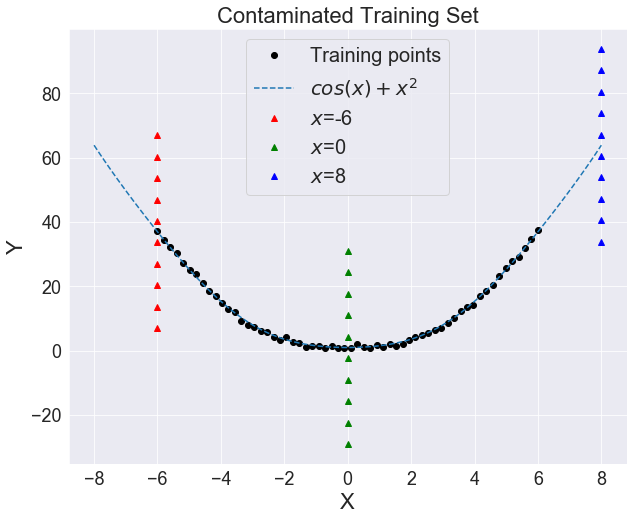

In [9]:
plt.figure(figsize=(10, 8))
label1 = '$cos(x)+x^2$'
plt.plot(X1,Y1,'ko',label='Training points')
plt.plot(X2,f_cos(X2),'--',label=label1)
labels = ['$x$='+str(i) for i in outliers]
for i in range(len(outliers)):
    plt.plot(outliers_x1[i],outliers_y1[i],'^', label=labels[i], c = line_colors[i])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Contaminated Training Set')
plt.legend()

In [10]:
def GP(X1, y1, X2, kernel_func, l, noise):
    """
    This function calculates the posterior mean and covariance matrix
    
    Args:
    (X1, y1): training set
    X2: test set
    kernel_func: kernel functions chosen from above covariance functions
    l: hyperparemeter
    noise: noise term 
    
    Returns:
    The posterior mean and covariance matrix
    """
    # Kernel of the training data
    K11 = kernel_func(X1, X1, l) + noise**2 * np.eye(len(X1))
    # Kernel of training data and test data
    K12 = kernel_func(X1, X2, l)
    # get the inverse 
    K11_inv = inv(K11)
    # posterior mean
    μ2 = (K12.T @ K11_inv).dot(y1)
    # posterior covariance
    K22 = kernel_func(X2, X2, l) + 1e-8 * np.eye(len(X2))
    K2 = K22 - (K12.T @ K11_inv @ K12)
    return μ2, K2  

In [11]:
def grad(X_train, Y_train, X_test, Y_test, noise, kernel_fun):
    '''
    This function returns the MSE function.
    
    '''
    def nll_naive(theta):
        ''''
        Returns a function
        
        Args:
        theta: specify the parameter term
        
        Returns:
        MSE function to be minimized
        
        ''''
        predicted = GP(X_train, Y_train, X_test, kernel_fun, theta, noise)[0]
        sqdist = (predicted - Y_test) ** 2
        mse = np.mean(sqdist)
        return mse
   
    return nll_naive
    



In [12]:
def optimum(X1,Y1,X2,Y2,noise,kernel_fun):
    '''
    This function runs the minimize algorithm several times to avoid local minima
    
    Returns:
    The optimal parameter
    
    '''
    temp = 100000000
    opt = 0
    for i in np.linspace(4,40,10):
        var = minimize(grad(X1, Y1, X2, Y2, noise, kernel_fun), [i], method='L-BFGS-B').x
        mse = grad(X1, Y1, X2, Y2, noise, kernel_fun)(var)
        if temp > mse:
            temp = mse
            opt = var
    return opt

In [13]:
optimum(X1,Y1,X2,Y2,noise,SE)

array([5.73933514])

In [49]:
def mse_gradient(x_train, y_train, x_test, y_test, noise, outliers_x, fun, kernel_fun):
    '''
    This function plots the sensitivity curve using Method 4 and outputs the vector of optimal parameters
    and time used.
    
    Args:
    Same as other methods.
    
    
    '''
    tic = time.perf_counter()
    best = optimum(x_train, y_train, x_test, y_test,noise, kernel_fun)
    perturb = np.linspace(-30, 30,10,8) # perturbation on y-axis
    # define outliers_y a n x m matrix, n = len(outliers_x), m = len(perturb)
    outliers_y = [[fun(outliers_x[i]) + _ for _ in perturb] for i in range(len(outliers_x))]
    # define var matrix the same size as outliers_y to store optimum values for each case
    var_opt = [[0]*len(perturb) for _ in range(len(outliers_x))]
    for i in range(len(outliers_x)):
        outlier_x = np.array([outliers_x[i]]).reshape(1, -1)
        X_train = np.append(x_train, outliers_x[i]).reshape(len(x_train)+1,1) # with the outlier
        for j in range(len(perturb)):
            Y_train = np.append(y_train, outliers_y[i][j]).reshape(len(y_train)+1,1)
            var_opt[i][j] = optimum(X_train,Y_train,x_test,y_test,noise,kernel_fun)
            
    plt.figure(figsize=(10, 8))
    labels = ['$x_0$='+str(i) for i in outliers_x]
    for i in range(len(outliers_x)):
        plt.plot(perturb, np.log(abs(var_opt[i] - best)), '-', marker='o', label=labels[i], c = line_colors[i])
    plt.xlabel('$y_{outlier} - f(x_0)$')
    plt.ylabel('$log(|SC(x_0)|)$')
#     plt.ylim(1.5,4.5)
#     plt.ylim(0,10)
    #plt.title('Sensitivity Curve of Amplitude in SE by Method 4')
    plt.legend()
    print(best)
    print(var_opt)
    toc = time.perf_counter()
    print(f"Finish the implementation in {toc - tic:0.4f} seconds")


## SE length scale

[5.73933509]
[[array([12.21887213]), array([12.34147939]), array([12.46359132]), array([12.58534336]), array([12.70690538]), array([12.8284427]), array([12.95014009]), array([13.07218778]), array([13.19479254]), array([13.31821371])], [array([12.19055566]), array([12.1802051]), array([12.16963709]), array([12.15884867]), array([12.14782567]), array([12.13656393]), array([12.12505756]), array([12.11330415]), array([12.10127615]), array([12.08898598])], [array([12.91175195]), array([13.09844915]), array([13.28179091]), array([13.46222453]), array([13.64023387]), array([13.81627149]), array([13.99089274]), array([14.16462306]), array([932.09348922]), array([3454.53922326])]]
Finish the implementation in 5.3454 seconds


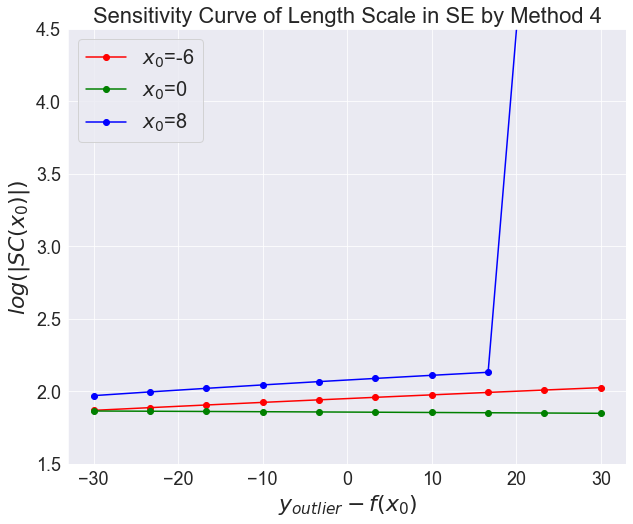

In [37]:
mse_gradient(X1, Y1, X2, Y2, noise, outliers, f_cos, SE)

[6.70197809]
[[array([26.21021479]), array([26.56863288]), array([26.94051126]), array([27.32638802]), array([27.72714183]), array([28.14376118]), array([28.57804157]), array([29.03135136]), array([29.50631992]), array([30.00569534])], [array([25.78311993]), array([25.75547832]), array([25.72730795]), array([25.69853863]), array([25.66908818]), array([25.63897334]), array([25.60814257]), array([25.57661957]), array([25.54432947]), array([25.51129897])], [array([28.23031308]), array([28.80450985]), array([29.4057172]), array([30.03677813]), array([30.70214109]), array([31.407104]), array([32.16029248]), array([32.9733053]), array([33.86285307]), array([34.85533084])]]
Finish the implementation in 3.3888 seconds


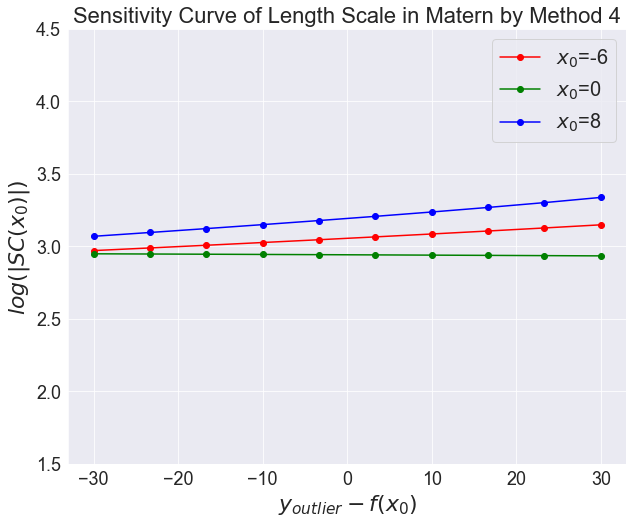

In [39]:
mse_gradient(X1, Y1, X2, Y2, noise, outliers, f_cos, Matern_3)

[7.64693334]
[[array([50.20565585]), array([51.24021703]), array([52.3920111]), array([53.66755133]), array([55.07737622]), array([56.63435709]), array([58.35681785]), array([60.26774612]), array([62.39676912]), array([64.78380237])], [array([47.90918944]), array([47.81245919]), array([47.71436301]), array([47.61495114]), array([47.51405753]), array([47.41176063]), array([47.30766153]), array([47.20333058]), array([47.09664459]), array([46.98874352])], [array([56.20002601]), array([58.20363094]), array([60.48517601]), array([63.08805754]), array([66.0708119]), array([69.51793482]), array([73.54946422]), array([78.33368866]), array([84.12483641]), array([91.29290726])]]
Finish the implementation in 7.3915 seconds


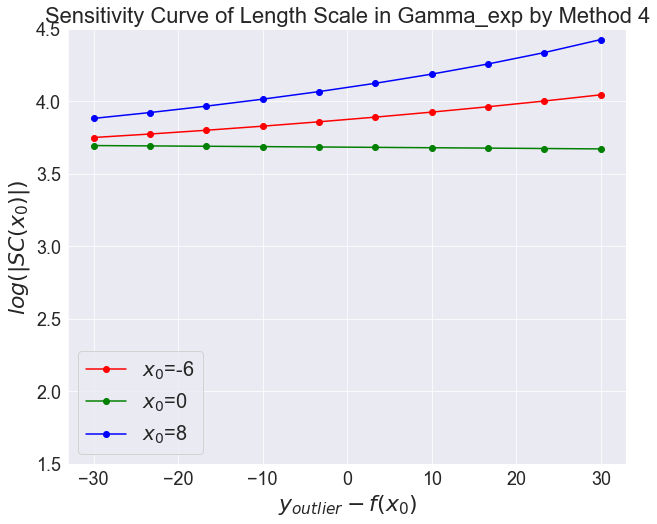

In [41]:
mse_gradient(X1, Y1, X2, Y2, noise, outliers, f_cos, Gamma_exp)

[5677.14201824]
[[array([-4.13949664]), array([-4.50141139]), array([-17.75072567]), array([-78.78642093]), array([4.48077731]), array([1.8849122]), array([1.07904843]), array([0.76295559]), array([0.59483788]), array([0.48972225])], [array([4.14396355]), array([4.17045483]), array([4.14208192]), array([4.0664899]), array([3.95192977]), array([3.80730346]), array([3.64149495]), array([3.46261589]), array([3.27732183]), array([3.09067427])], [array([0.62341092]), array([0.50576234]), array([0.42580347]), array([0.36838117]), array([0.32525516]), array([0.29169072]), array([0.26481159]), array([0.24278218]), array([0.22438031]), array([0.20876256])]]
Finish the implementation in 5.6645 seconds


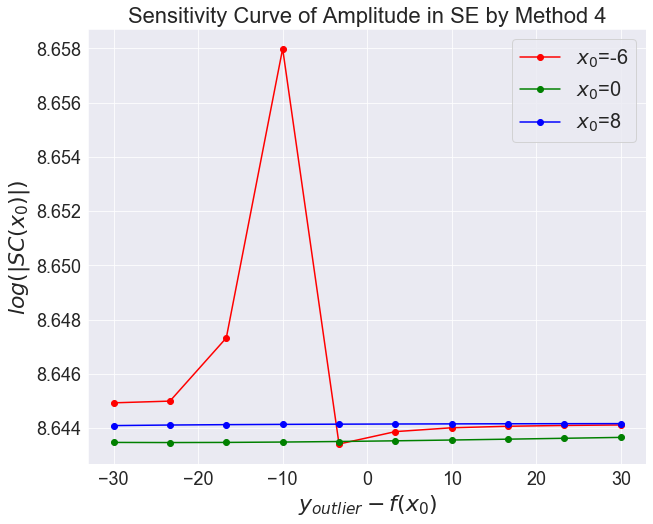

In [50]:
mse_gradient(X1, Y1, X2, Y2, noise, outliers, f_cos, SE_amp)